In [2]:
import glob
import os.path as osp
import string
from tqdm import tqdm
from pathlib import Path
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms
from torchvision.models import resnet18, resnet50, resnet101
import matplotlib.pyplot as plt
import collections
collections.Iterable = collections.abc.Iterable
from IPython.display import clear_output
%matplotlib inline
plt.style.use('seaborn')

/tmp/ipykernel_28/3175357256.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)
print(device)

cuda:0


In [4]:
def plot_loss(epoch: int,
              train_losses: list,
              val_losses: list,
              n_steps: int = 100):

    # clear previous graph
    clear_output(True)
    # making titles
    train_title = f'Epoch:{epoch} | Train Loss:{np.mean(train_losses[-n_steps:]):.6f}'
    val_title = f'Epoch:{epoch} | Val Loss:{np.mean(val_losses[-n_steps:]):.6f}'

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(train_losses)
    ax[1].plot(val_losses)

    ax[0].set_title(train_title)
    ax[1].set_title(val_title)

    plt.show()

def print_prediction(model, dataset, device, label_converter):
    idx = np.random.randint(len(dataset))
    path = dataset.img_list[idx]

    with torch.no_grad():
        model.eval()
        img, target_text = dataset[idx]
        img = img.unsqueeze(0)
        logits = model(img.to(device))

    pred_text = decode_prediction(logits.cpu(), label_converter)

    # img = np.asarray(Image.open(path).convert('L'))
    img = np.asarray(Image.open(path))
    title = f'Truth: {target_text} | Pred: {pred_text}'
    plt.imshow(img)
    plt.title(title)
    plt.axis('off');

In [5]:
class strLabelConverter(object):

    def __init__(self, alphabet: str, ignore_case: bool = True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.char2idx = {}
        for i, char in enumerate(alphabet):
            self.char2idx[char] = i + 1
        self.idx2char = {idx: char for char, idx in self.char2idx.items()}

    def encode(self, text):
        if isinstance(text, str):
            text = [
                self.char2idx[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
        return texts


def decode_prediction(logits: torch.Tensor,
                      label_converter: strLabelConverter) -> str:
    tokens = logits.softmax(2).argmax(2)
    tokens = tokens.squeeze(1).numpy()

    # convert tor stings tokens
    tokens = ''.join([label_converter.idx2char[token]
                      if token != 0  else '-'
                      for token in tokens])
    tokens = tokens.split('-')

    # remove duplicates
    text = [char
            for batch_token in tokens
            for idx, char in enumerate(batch_token)
            if char != batch_token[idx-1] or len(batch_token) == 1]
    text = ''.join(text)
    return text

In [6]:
class blockCNN(nn.Module):
    def __init__(self, in_nc, out_nc, kernel_size, padding, stride=1):
        super(blockCNN, self).__init__()
        self.in_nc = in_nc
        self.out_nc = out_nc
        self.kernel_size = kernel_size
        self.padding = padding
        # layers
        self.conv = nn.Conv2d(in_nc, out_nc,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding)
        self.bn = nn.BatchNorm2d(out_nc)

    def forward(self, batch, use_bn=False, use_relu=False,
                use_maxpool=False, maxpool_kernelsize=None):
        batch = self.conv(batch)
        if use_bn:
            batch = self.bn(batch)
        if use_relu:
            batch = F.relu(batch)
        if use_maxpool:
            assert maxpool_kernelsize is not None
            batch = F.max_pool2d(batch, kernel_size=maxpool_kernelsize, stride=2)
        return batch

class blockRNN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, bidirectional, dropout=0):
        super(blockRNN, self).__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.bidirectional = bidirectional
        # layers
        self.gru = nn.GRU(in_size, hidden_size, bidirectional=bidirectional)

    def forward(self, batch, add_output=False):
        batch_size = batch.size(1)
        outputs, hidden = self.gru(batch)
        out_size = int(outputs.size(2) / 2)
        if add_output:
            outputs = outputs[:, :, :out_size] + outputs[:, :, out_size:]
        return outputs

In [7]:
alphabet = "/" + string.digits
label_converter = strLabelConverter(alphabet)
alphabet

'/0123456789'

In [8]:
train_anno = "/kaggle/input/crnn18/data/train_anno.csv"
val_anno = "/kaggle/input/crnn18/data/val_anno.csv"

In [9]:
def make_datapath_list(phase, anno_file):
    root_path = "/kaggle/input/crnn18/data/"
    imgs_anno = pd.read_csv(anno_file)
    img_name = imgs_anno["img"] #all img
    path_list = []

    for i in range(len(img_name)):
        path = osp.join(root_path + phase + "/" + img_name[i])
        path_list.append(path)

    return path_list

train_img_list = make_datapath_list("train", train_anno)
print(train_img_list[0])

val_img_list = make_datapath_list("val", val_anno)
print(val_img_list[0])


/kaggle/input/crnn18/data/train/10012006_0.jpg
/kaggle/input/crnn18/data/val/15111979_0.jpg


In [10]:
class DataTransform():
    def __init__(self):
        self.data_transform = {
                    'train': transforms.Compose([
#                         transforms.Resize((50, 250)),
                        transforms.ToTensor()
                    ]),
                    'val': transforms.Compose([
#                         transforms.Resize((50, 250)),
                        transforms.ToTensor()
                    ]),
                    'test': transforms.Compose([
                        transforms.Resize((50, 250)),
                        transforms.ToTensor()
                    ])
                }

    def __call__(self, phase, img):
        return self.data_transform[phase](img)

In [11]:
transform = DataTransform()

10/01/2006


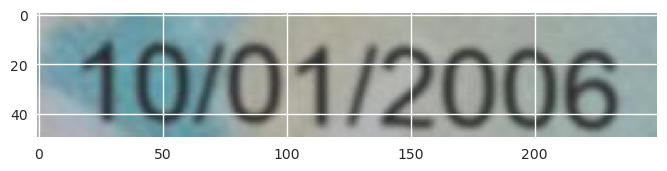

15/11/1979


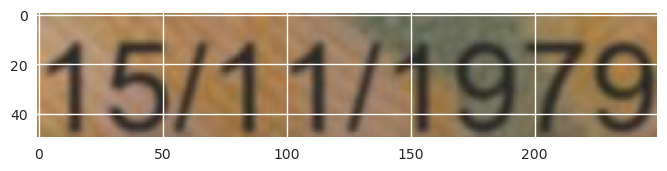

In [12]:
class MyDataset():
    def __init__(self, img_list, phase, transform, csv_file):
        self.img_list = img_list
        self.phase = phase
        self.transform = transform
        self.csv_file = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        img = Image.open(img_path).convert('RGB')
        img_transform = self.transform(self.phase, img)
        labels = self.csv_file["label"].values # all labels
        label = labels[idx]

        return img_transform, label


train_dataset = MyDataset(train_img_list, "train", transform, train_anno)
img, label = train_dataset.__getitem__(0)
print(label)
img = img.permute(1, 2, 0)
plt.imshow(img)
plt.show()

val_dataset = MyDataset(val_img_list, "val", transform, val_anno)
img_val, label_val = val_dataset.__getitem__(0)
print(label_val)
img_val = img_val.permute(1, 2, 0)
plt.imshow(img_val)
plt.show()

In [14]:
batch_size = 64
train_dataloader = data.DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size, shuffle=False)

dataloader_dict = {
    "train": train_dataloader,
    "val": val_dataloader
}

In [15]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [16]:
class CRNN(nn.Module):
    def __init__(self, hidden_size: int,
                 vocab_size: int,
                 bidirectional: bool = True,
                 dropout: float = 0.5):
        super(CRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.bidirectional = bidirectional
        # make layers
        # convolutions
        resnet = resnet101(pretrained=True)
        modules = list(resnet.children())[:-3]
        self.resnet = nn.Sequential(*modules)
        #PRETRAINED^



#         self.cn6 = blockCNN(256, 256, kernel_size=3, padding=1)
        self.cn6 = blockCNN(1024, 256, kernel_size=3, padding=1)

        # RNN + Linear
#         self.linear1 = nn.Linear(1024, 256)

        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        
        self.gru1 = blockRNN(256, hidden_size, hidden_size,
                             dropout=dropout,
                             bidirectional=bidirectional)
        self.gru2 = blockRNN(hidden_size, hidden_size, vocab_size,
                             dropout=dropout,
                             bidirectional=bidirectional)
        self.linear3 = nn.Linear(hidden_size * 2, vocab_size)

    def forward(self, batch: torch.Tensor):
        batch_size = batch.size(0)
        # convolutions
        batch = self.resnet(batch)
        batch = self.cn6(batch, use_relu=True, use_bn=True)
        # make sequences of image features
        batch = batch.permute(0, 3, 1, 2)
        n_channels = batch.size(1)
        batch = batch.view(batch_size, n_channels, -1)
        batch = self.linear1(batch)
        batch = self.linear2(batch)
        # rnn layers
        batch = self.gru1(batch, add_output=True)
        batch = self.gru2(batch)
        # output
        batch = self.linear3(batch)
        batch = batch.permute(1, 0, 2)
        return batch

In [44]:
hidden_size = 256
vocab_size = len(alphabet) + 1 # extra character for blank symbol
bidirectional = True
dropout = 0.4
weight_decay = 1e-4
momentum = 0.9
clip_norm = 1
print(vocab_size)

12


In [45]:
imgs, labels = next(iter(train_dataloader))

In [20]:
crnn = CRNN(hidden_size=hidden_size, vocab_size=vocab_size,
            bidirectional=bidirectional, dropout=dropout).to(device)
crnn(imgs.to(device)).shape

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:09<00:00, 19.7MB/s]   


torch.Size([16, 64, 12])

In [46]:
lr = 1e-3
optimizer = torch.optim.SGD(crnn.parameters(), lr=lr, nesterov=True,
                            weight_decay=weight_decay, momentum=momentum)
critertion = nn.CTCLoss(blank=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=10)

In [47]:
def validation(model, val_losses, label_converter):
    with torch.no_grad():
        model.eval()
        for batch_img, batch_text in val_dataloader:
            logits = crnn(batch_img.to(device))
            val_loss = calculate_loss(logits, batch_text, label_converter)
            val_losses.append(val_loss.item())
    return val_losses

In [23]:
def calculate_loss(logits, texts, label_converter):
    # get infomation from prediction
    device = logits.device
    input_len, batch_size, vocab_size = logits.size()
    # encode inputs
    logits = logits.log_softmax(2)
    encoded_texts, text_lens = label_converter.encode(texts)
    logits_lens = torch.full(size=(batch_size,), fill_value=input_len, dtype=torch.int32)
    # calculate ctc
    loss = critertion(logits, encoded_texts,
                      logits_lens.to(device), text_lens)
    return loss

In [35]:
train_losses = []
val_losses = []
val_epoch_len = len(val_dataset) // batch_size
val_epoch_len

191

In [36]:
def acc_calc(model, dataset, label_converter) -> float:
    acc = 0
    with torch.no_grad():
        model.eval()
        for idx in range(len(dataset)):
            img, text = dataset[idx]
            logits = model(img.unsqueeze(0).to(device))
            pred_text = decode_prediction(logits.cpu(), label_converter)

            if pred_text == text:
                acc += 1

    return acc / len(dataset)

In [37]:
max_epoch = 10

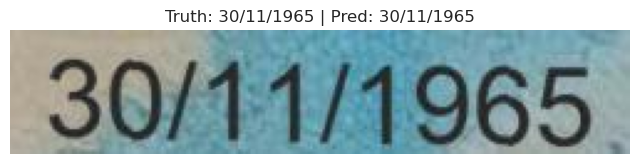

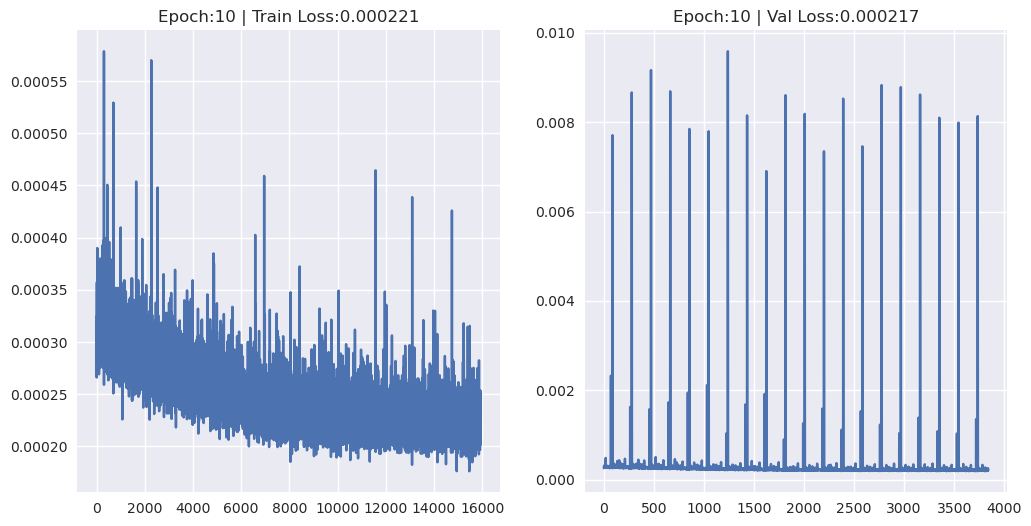

Saved model


100%|██████████| 10/10 [36:30<00:00, 219.03s/it]

Saved parameter
Epoch: 10/10


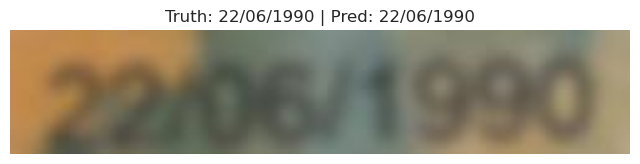

In [48]:
crnn.to(device)

for ep in tqdm(range(max_epoch), colour="red"):

    crnn.train()
    for inputs, labels in dataloader_dict["train"]:
        inputs = inputs.to(device) # (20, 3, 224, 224)

        optimizer.zero_grad()

        outputs = crnn(inputs)
            # calculate loss
        train_loss = calculate_loss(outputs, labels, label_converter)
        if np.isnan(train_loss.detach().cpu().numpy()):
            continue
        train_losses.append(train_loss.item())
            # make backward
        train_loss.backward()

        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()
        
        
        
    val_losses = validation(crnn, val_losses, label_converter)
    
    # printing progress
    plot_loss(ep+1, train_losses, val_losses)
    
#     val_acc = acc_calc(crnn, val_dataset, label_converter)
#     print("Val acc: ", val_acc)
    
    print_prediction(crnn, val_dataset, device, label_converter)

    scheduler.step(val_losses[-1])
    if ((ep+1) % 10 == 0): # 10 epoch lại lưu
        torch.save(crnn.state_dict(), "/kaggle/working/crnn_" + str(ep+1) + ".pth")
        print("Saved model")
        # lưu checkpoint
        torch.save({
            'epoch': ep,
            'model_state_dict': crnn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss
            }, "/kaggle/working/crnn_params" + str(ep+1) + ".pth")
        print("Saved parameter")

    print('Epoch: {}/{}'.format(ep+1, max_epoch))


In [ ]:
max_epoch = 40


checkpoint = torch.load("/kaggle/input/crnn-ep40/crnn_params40.pth")
crnn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

crnn.to(device)
for ep in tqdm(range(max_epoch), colour="cyan"):

    crnn.train()
    for inputs, labels in dataloader_dict["train"]:
        inputs = inputs.to(device) # (20, 3, 224, 224)

        optimizer.zero_grad()

        outputs = crnn(inputs)
            # calculate loss
        train_loss = calculate_loss(outputs, labels, label_converter)
        if np.isnan(train_loss.detach().cpu().numpy()):
            continue
        train_losses.append(train_loss.item())
            # make backward
        train_loss.backward()

        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    val_losses = validation(crnn, val_losses, label_converter)
    
#     val_acc = acc_calc(crnn, val_dataset, label_converter)
#     print('Validaton Accuracy: ', val_acc)
    
    # printing progress
    plot_loss(ep+1, train_losses, val_losses)
    print_prediction(crnn, val_dataset, device, label_converter)

    scheduler.step(val_losses[-1])
    if ((ep+1) % 10 == 0): # 10 epoch lại lưu
        torch.save(crnn.state_dict(), "/kaggle/working/crnn_" + str(ep+1) + ".pth")
        print("Saved model")
        # lưu checkpoint
        torch.save({
            'epoch': ep,
            'model_state_dict': crnn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss
            }, "/kaggle/working/crnn_params" + str(ep+1) + ".pth")
        print("Saved parameter")

    print('Epoch: {}/{}'.format(ep+1, max_epoch))

In [49]:
val_acc = acc_calc(crnn, val_dataset, label_converter)
train_acc = acc_calc(crnn, train_dataset, label_converter)
print('Validaton Accuracy: ', val_acc)
print('Training Accuracy: ', train_acc)

Validaton Accuracy:  0.5748025083475853
Training Accuracy:  0.5648353372692858


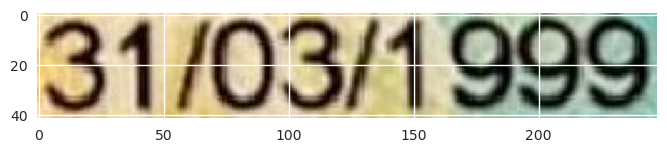

In [50]:
test_anno = "/kaggle/input/crnn18/data/test_anno.csv"
test_img_list = make_datapath_list("test", test_anno)
test_dataset = MyDataset(test_img_list, "test", transform, test_anno)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

img = plt.imread(test_img_list[0])
plt.imshow(img)

In [ ]:
img_train, label_train = train_dataset.__getitem__(0)
print(label_train)
print(img_train.shape)
print("-----"*15)

img_val, label_val = val_dataset.__getitem__(0)
print(label_val)
print(img_val.shape)
print("-----"*15)

img_test, label_test = test_dataset.__getitem__(0)
print(label_test)
print(img_test.shape)

In [41]:
import cv2
def predict(model, dataset, device, label_converter):
    # idx = np.random.randint(len(dataset))
    predict_text = []
    actual_text = []
    for i in range(len(dataset)):
        path = dataset.img_list[i]

        with torch.no_grad():
            model.eval()
            img, target_text = dataset[i]
            actual_text.append(target_text)
            img = img.unsqueeze(0)
            logits = model(img.to(device))


        pred_text = decode_prediction(logits.cpu(), label_converter)
        predict_text.append(pred_text)


    for i in range(len(dataset)):
#         img = np.asarray(Image.open(dataset.img_list[i]).convert('L'))
        img = np.asarray(Image.open(dataset.img_list[i]))
        plt.imshow(img)
        if actual_text[i] != predict_text[i]:
            title = f'Ground truth: {actual_text[i]} | Predict: {predict_text[i]}'
            plt.title(title, color="red")
        else:
            title = f'Ground truth: {actual_text[i]} | Predict: {predict_text[i]}'
            plt.title(title)

        plt.axis('off')
        plt.show()

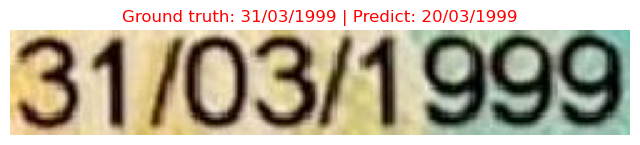

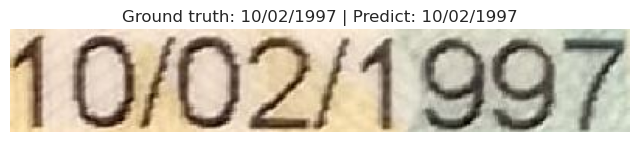

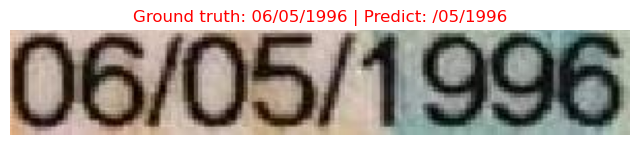

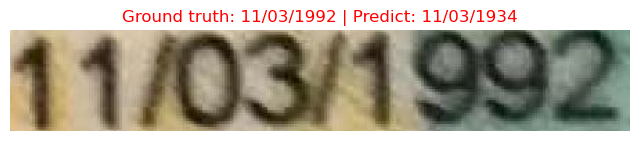

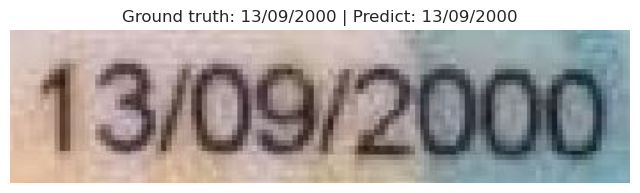

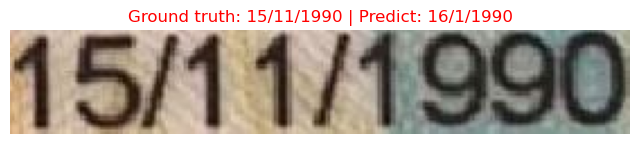

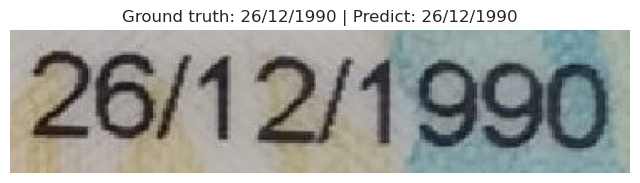

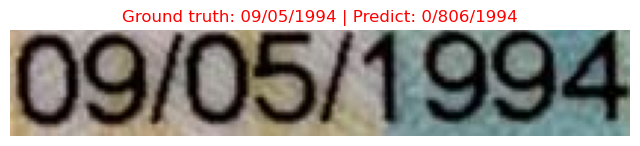

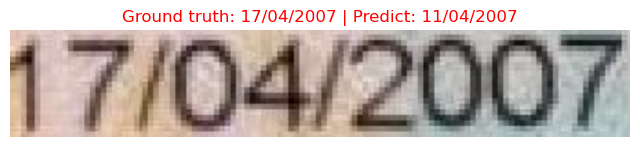

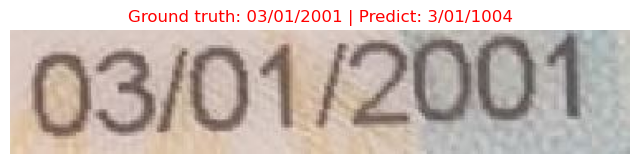

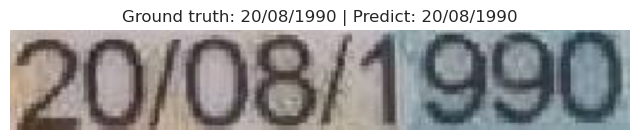

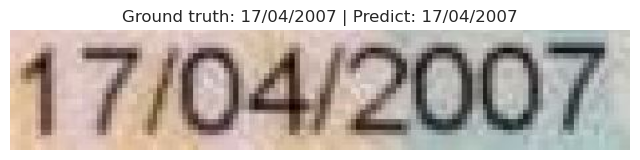

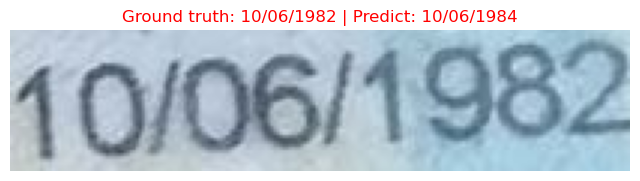

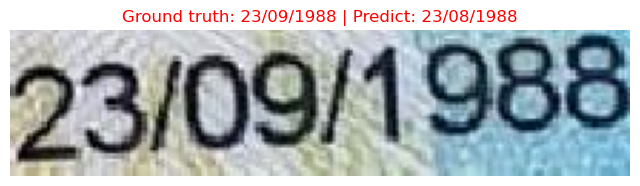

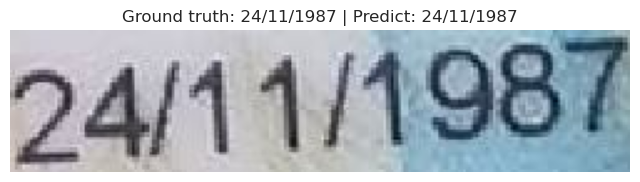

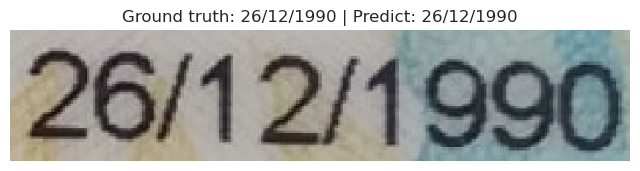

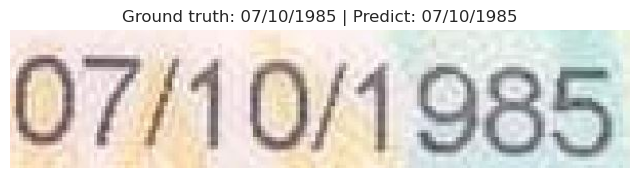

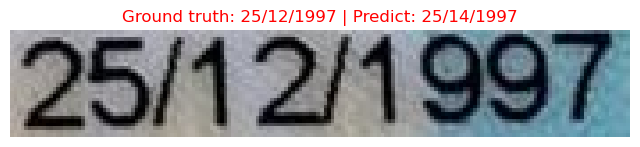

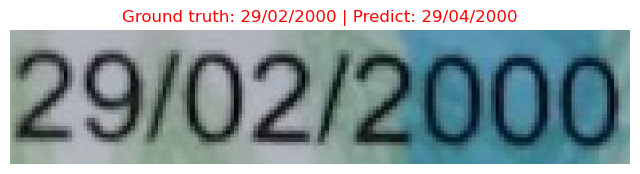

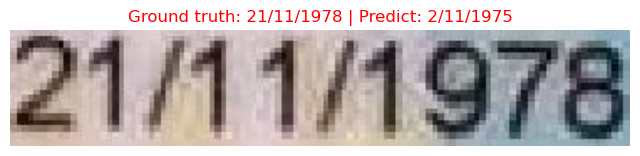

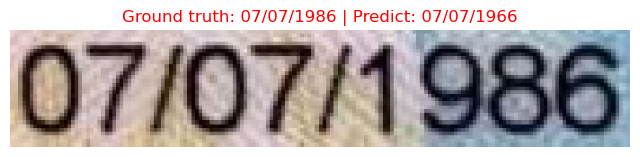

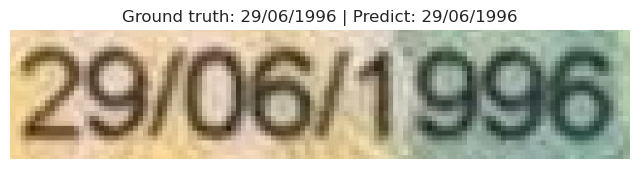

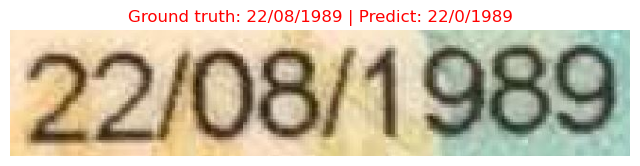

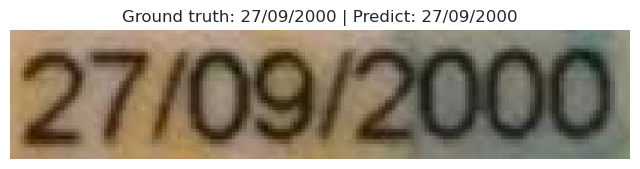

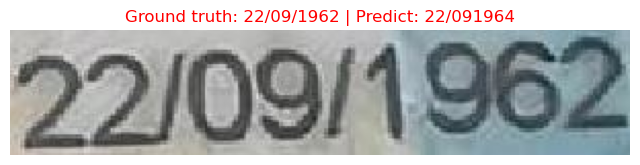

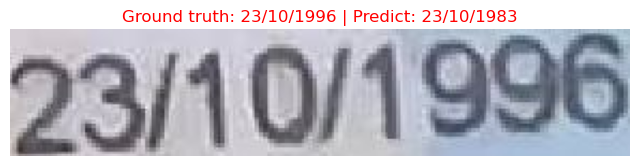

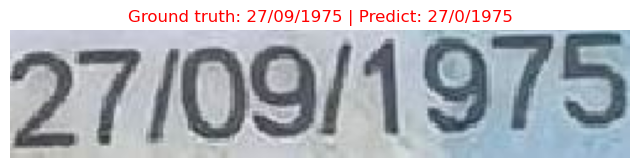

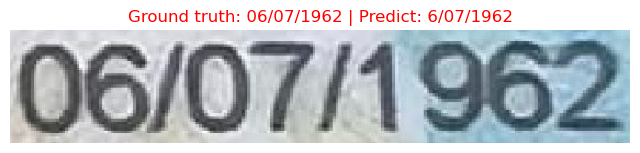

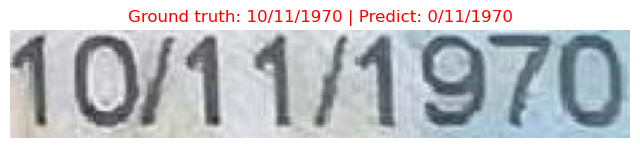

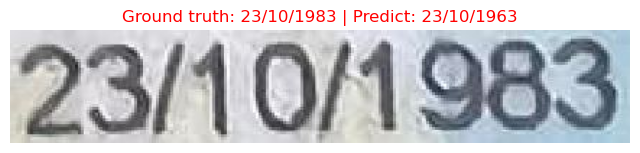

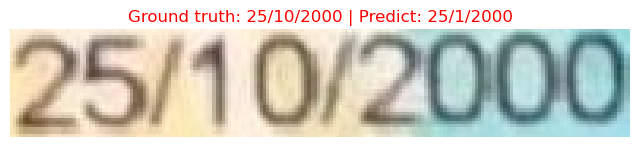

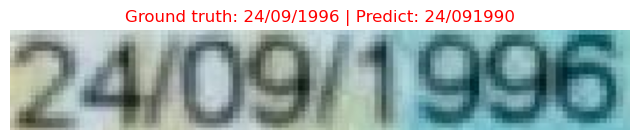

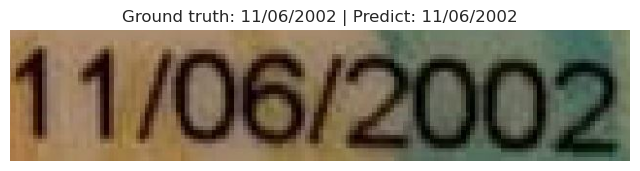

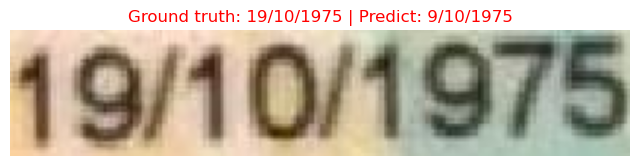

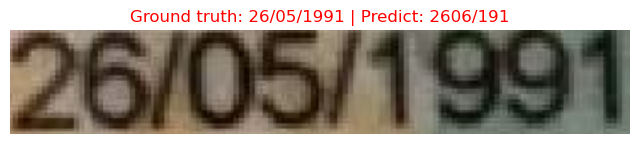

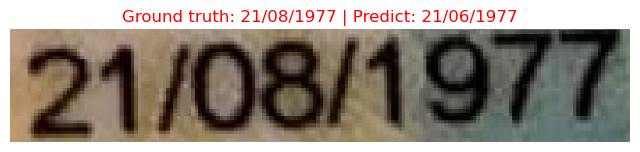

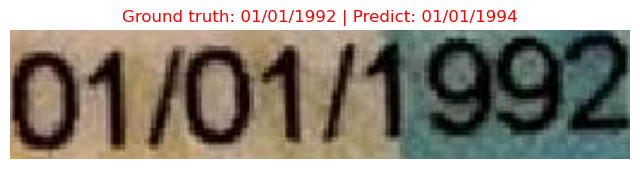

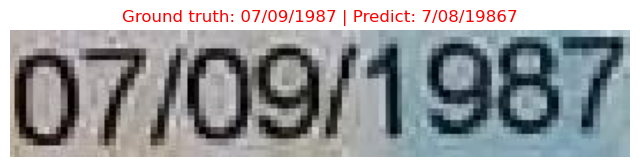

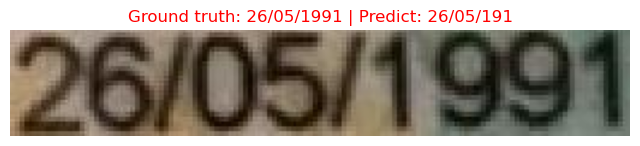

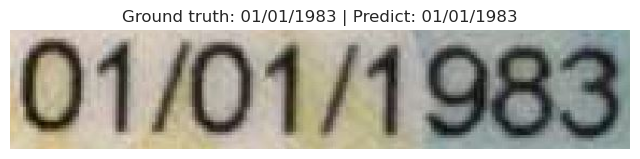

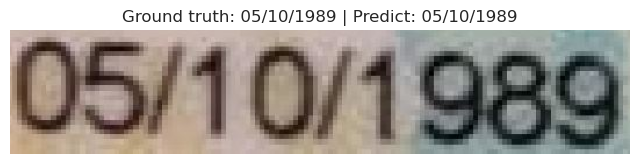

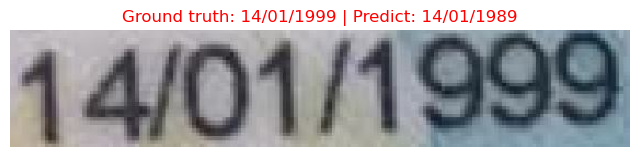

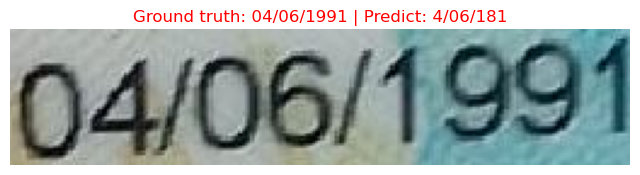

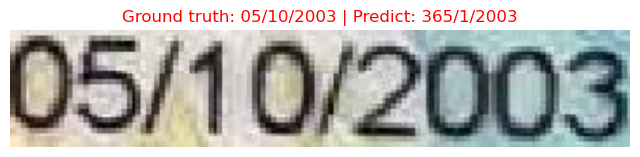

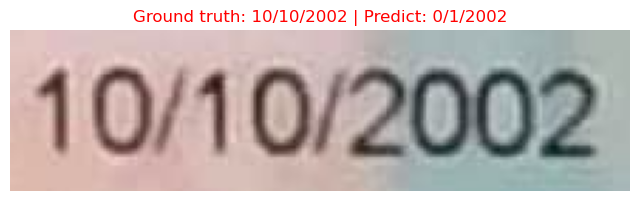

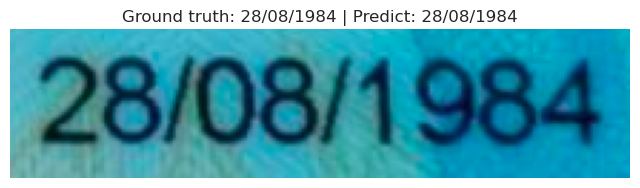

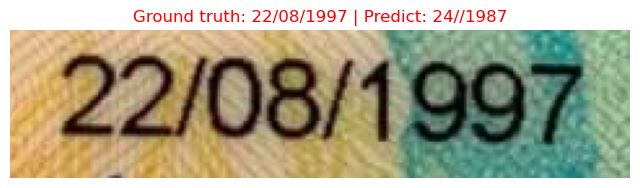

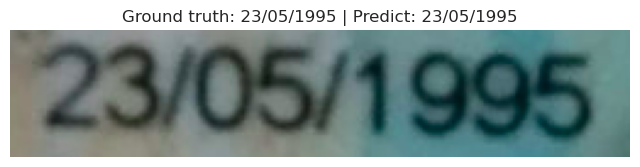

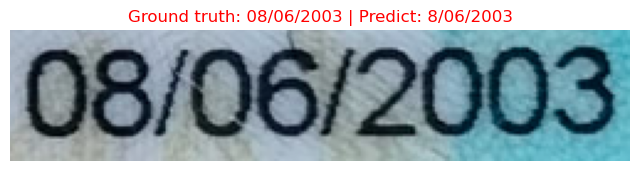

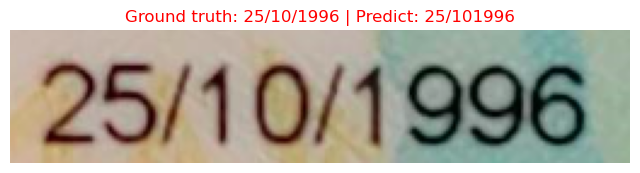

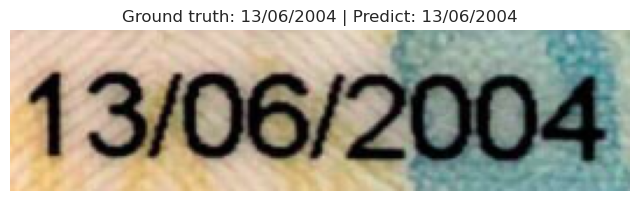

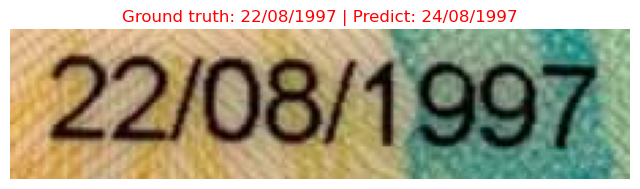

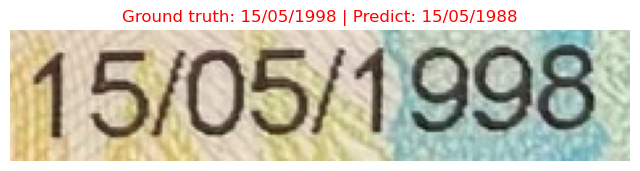

In [51]:
predict(crnn, test_dataset, device, label_converter)

In [53]:
test_acc = acc_calc(crnn, test_dataset, label_converter)
print('Test Accuracy: ', test_acc)

Test Accuracy:  0.3018867924528302
